# Preprocess Traffic dataset (PEMS-SF)

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Open train/set files

In [22]:
f = open('../data/raw/pems+sf/PEMS_train', 'r')
train_set = f.readlines()

f = open('../data/raw/pems+sf/PEMS_test', 'r')
test_set = f.readlines()

f = open('../data/raw/pems+sf/PEMS_trainlabels', 'r')
train_labels = f.read()

f = open('../data/raw/pems+sf/PEMS_testlabels', 'r')
test_labels = f.read()

## Convert from matlab format to numpy

In [9]:
train_labels_array = np.array([int(c) for c in train_labels[1:-2].split()])
test_labels_array = np.array([int(c) for c in test_labels[1:-2].split()])

total_labels = np.concatenate([train_labels_array, test_labels_array], axis=0)

total_labels.shape

(440,)

In [10]:
train_series = [[[float(t) for t in xt.split(' ')] for xt in series[1:-2].split(';')] for series in train_set]
train_series = np.array(train_series)

test_series = [[[float(t) for t in xt.split(' ')] for xt in series[1:-2].split(';')] for series in test_set]
test_series = np.array(test_series)

train_series.shape, test_series.shape

((267, 963, 144), (173, 963, 144))

In [11]:
total = np.concatenate([train_series, test_series], axis=0)
total.shape

(440, 963, 144)

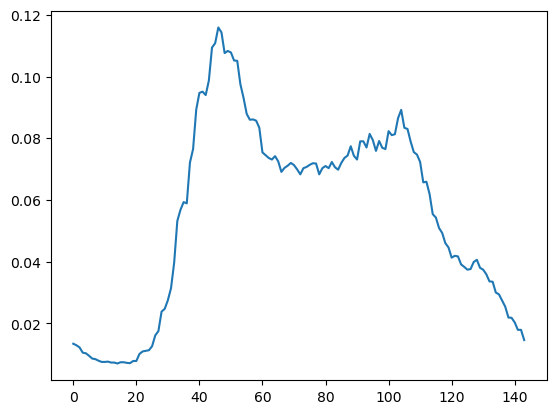

In [12]:
plt.plot(total[0, 10, :])

## Reverse random order via perm vector

In [13]:
perms = "[246 247 431 118 381 389 13 406 277 357 78 215 369 120 160 433 103 9 440 2 29 73 416 10 411 300 428 55 219 15 392 412 170 41 65 333 383 264 259 63 116 22 168 258 291 204 407 305 77 148 152 115 166 173 320 282 229 142 163 312 133 139 421 128 351 243 100 287 112 413 370 313 169 384 51 380 285 99 124 278 276 224 149 159 254 241 113 263 262 181 232 395 1 292 410 302 86 290 48 123 280 364 36 156 184 144 172 335 289 326 28 62 362 269 94 44 358 117 49 68 332 378 401 275 271 422 98 201 415 87 405 322 234 319 125 303 59 250 150 344 31 310 427 353 176 88 50 240 35 171 334 327 403 434 14 6 67 396 130 131 331 265 158 394 268 328 283 348 141 165 92 205 119 95 24 16 251 274 162 325 45 388 373 194 237 208 233 420 329 230 177 175 367 418 345 342 191 218 146 71 238 97 186 330 157 47 417 314 52 145 221 435 61 382 105 132 66 57 187 89 338 203 235 58 346 324 391 7 419 408 355 217 307 21 321 11 70 104 439 96 202 400 354 430 228 393 360 308 108 138 317 143 101 436 206 425 374 390 134 309 323 18 136 90 301 188 284 349 245 154 110 397 151 81 261 244 42 32 193 299 293 359 153 40 180 127 23 398 347 222 298 352 12 336 337 3 4 438 182 253 426 129 223 252 404 17 79 196 270 366 424 377 294 296 304 25 197 311 213 371 372 256 399 121 220 114 211 340 38 414 83 249 339 209 30 82 437 318 214 387 107 375 297 39 379 190 33 74 27 306 260 46 75 248 409 272 386 174 273 295 212 102 155 239 178 316 402 368 189 281 195 76 286 257 356 8 423 255 93 111 365 135 91 20 200 432 315 185 226 80 210 207 236 43 167 216 126 85 227 109 53 161 385 56 183 54 26 69 225 361 19 179 5 122 343 72 341 164 267 64 192 266 199 106 137 147 363 37 279 140 350 60 429 198 288 231 34 376 242 84]"

perms = [int(i)-1 for i in perms[1:-1].split(' ')]
perms = np.array(perms)

total_ordered = total[perms]
total_labels_ordered = total_labels[perms]

In [14]:
total_ordered.shape, total_labels_ordered.shape

((440, 963, 144), (440,))

## (n_days, n_sensors, n_steps) --> (n_sensors, n_days*n_steps)

In [15]:
total_10m = total_ordered.swapaxes(0, 1).reshape(-1, 440*6*24) # six 10 min in hour = 6 * 24
total_20m = total_ordered[:, :, ::2].swapaxes(0, 1).reshape(-1, 440*3*24) # three 20 min in hour = 3 * 24
total_1h  = total_ordered[:, :, ::6].swapaxes(0, 1).reshape(-1, 440*1*24) # 1 hour = 1*24

total_10m_labels = total_labels_ordered.repeat(6*24)
total_20m_labels = total_labels_ordered.repeat(3*24)
total_1h_labels = total_labels_ordered.repeat(1*24)

In [16]:
total_10m.shape, total_10m_labels.shape

((963, 63360), (63360,))

## Visualize without covariates

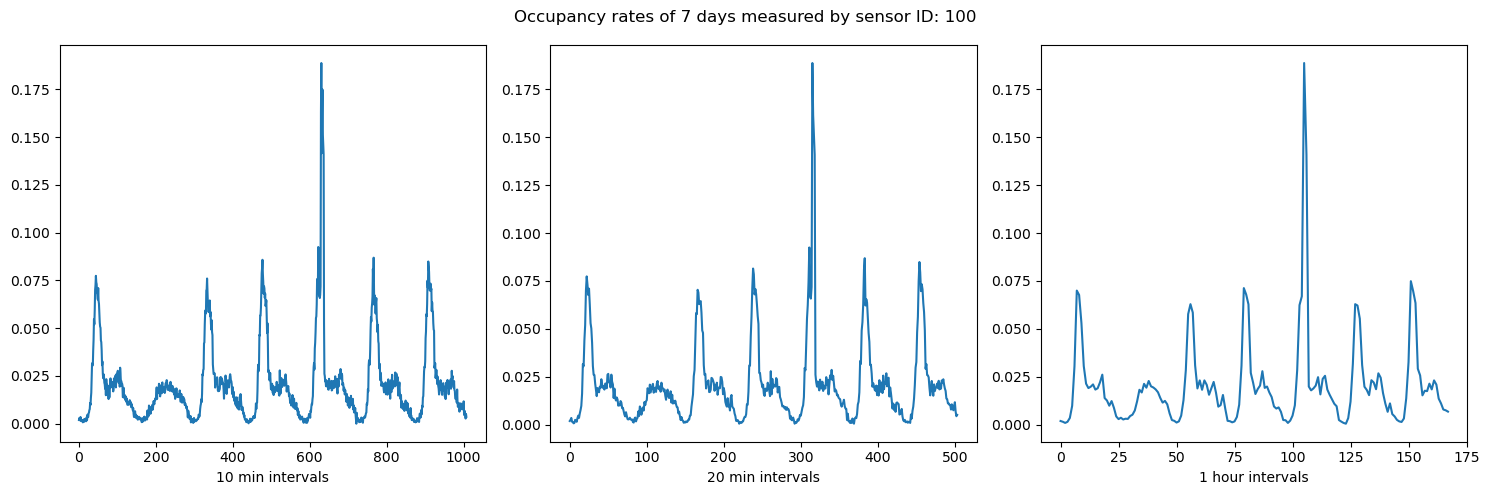

In [17]:
DAYS = 7
SENSOR_ID = 100

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.plot(total_10m[SENSOR_ID, :DAYS*6*24])
ax1.set_xlabel('10 min intervals')

ax2.plot(total_20m[SENSOR_ID, :DAYS*3*24])
ax2.set_xlabel('20 min intervals')

ax3.plot(total_1h[SENSOR_ID, :DAYS*1*24])
ax3.set_xlabel('1 hour intervals')

fig.suptitle(f'Occupancy rates of {DAYS} days measured by sensor ID: {SENSOR_ID}')
plt.tight_layout()

## Add covariates (minutes, day of week)

In [18]:
n_days = np.arange(0, 440) % 7 # 440 total days of occupancy recordings
covariate_10m = np.arange(0, 440*6*24)*10
covariate_20m = np.arange(0, 440*3*24)*20
covariate_1h  = np.arange(0, 440*1*24)*60

df_10m = np.concatenate([covariate_10m[..., None], n_days.repeat(6*24)[..., None], total_10m.T], axis=1)
df_20m = np.concatenate([covariate_20m[..., None], n_days.repeat(3*24)[..., None], total_20m.T], axis=1)
df_1h = np.concatenate([covariate_1h[..., None], n_days.repeat(1*24)[..., None], total_1h.T], axis=1)

## Visualize with covariates

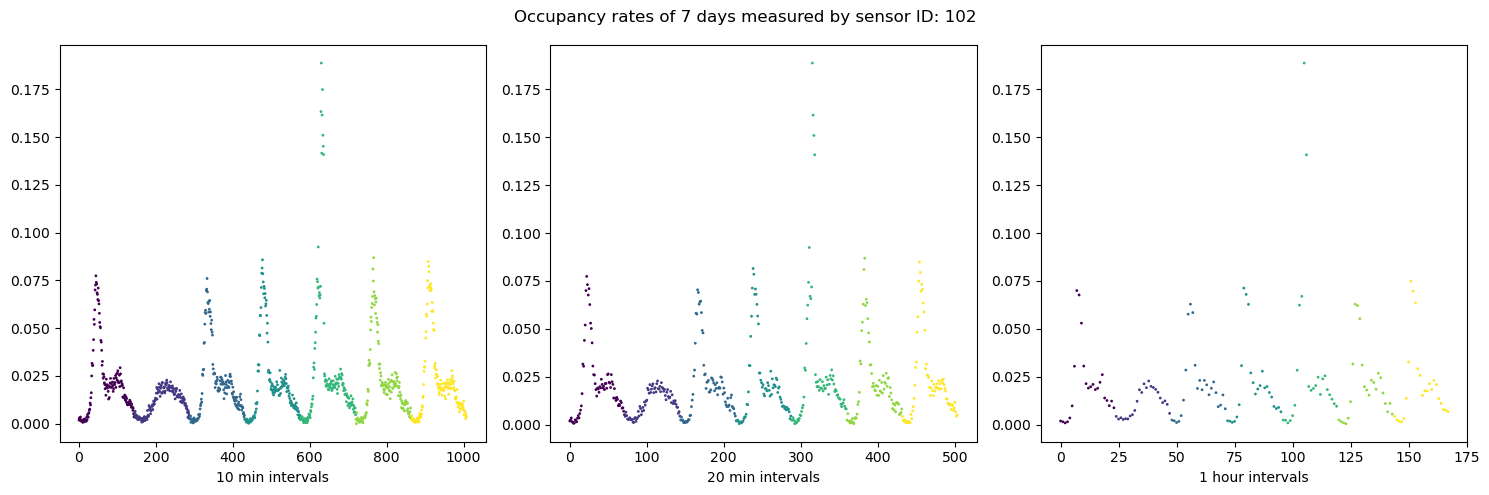

In [19]:
DAYS = 7
SENSOR_ID = 102

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

range_10m = range(len(df_10m[:DAYS*6*24]))
col_10m = df_10m[:DAYS*6*24, 1]
occ_10m = df_10m[:DAYS*6*24, SENSOR_ID]
ax1.scatter(range_10m, occ_10m, s=1, c=col_10m)
ax1.set_xlabel('10 min intervals')

range_20m = range(len(df_20m[:DAYS*3*24]))
col_20m = df_20m[:DAYS*3*24, 1]
occ_20m = df_20m[:DAYS*3*24, SENSOR_ID]
ax2.scatter(range_20m, occ_20m, s=1, c=col_20m)
ax2.set_xlabel('20 min intervals')

range_1h = range(len(df_1h[:DAYS*1*24]))
col_1h = df_1h[:DAYS*1*24, 1]
occ_1h = df_1h[:DAYS*1*24, SENSOR_ID]
ax3.scatter(range_1h, occ_1h, s=1, c=col_1h)
ax3.set_xlabel('1 hour intervals')

fig.suptitle(f'Occupancy rates of {DAYS} days measured by sensor ID: {SENSOR_ID}')
plt.tight_layout()

## Save as csv files 

In [20]:
pd_df_10m = pd.DataFrame(df_10m)
pd_df_10m = pd_df_10m.rename(columns={0: 'minutes', 1: 'day'})

pd_df_20m = pd.DataFrame(df_20m)
pd_df_20m = pd_df_20m.rename(columns={0: 'minutes', 1: 'day'})

pd_df_1h = pd.DataFrame(df_1h)
pd_df_1h = pd_df_1h.rename(columns={0: 'minutes', 1: 'day'})

pd_df_10m.to_csv('../data/processed/traffic_10m.csv', index=False)
pd_df_20m.to_csv('../data/processed/traffic_20m.csv', index=False)
pd_df_1h.to_csv('../data/processed/traffic_1h.csv', index=False)